_Since we announced [our collaboration with the World Bank and more partners to create the Open Traffic platform](https://mapzen.com/blog/announcing-open-traffic/), we’ve been busy. We’ve shared [two](https://mapzen.com/blog/open-traffic-osmlr-technical-preview/) [technical](https://mapzen.com/blog/osmlr-2nd-technical-preview/) previews of the OSMLR linear referencing system. Now we’re ready to share more about how we’re using [Mapzen Map Matching](https://mapzen.com/blog/map-matching/) to “snap” GPS-derived locations to OSMLR segments, and how we’re using a data-driven approach to evaluate and improve the algorithms._

# A "data-driven" approach to improving map-matching - Part IV: 
## _MAP-MATCHING & THE BUILT ENVIRONMENT_
=============================================================================================

## Background

So far we have seen that map-matching accuracy can be affected by both variables we can fix over time (e.g. GPS sample rate) and those we cannot (e.g. GPS accuracy/noise). The ability to predetermine a **sample rate** allows us measure its impact on match error and [make recommendations](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/master/notebooks/map_matching_part_I.ipynb#4.-Results) to our data partners regarding the fidelity of their data. Conversely, because GPS **positional accuracy** is so highly variable, we must make a more [nuanced decision][1] about the range of expected noise levels for which we wish to optimize the algorithm.
 [1]: http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/master/notebooks/map_matching_part_II.ipynb#b)-Customizing-our-search-space

A third kind of variable that impacts map-matching performance are those related to the **built environment**. Like GPS sample rate, built environment characteristics remain **fixed** in the short term. However, like GPS _accuracy_, we have no ability to control them. Thus, despite our intuition about the impact of something like road network density on match performance, we cannot recommend that a data provider build a less dense road network. Nevertheless, it is still worthwhile to quantify the relationship between built environment characteristics and map-matching performance for two principal reasons: 
1. to help **set expectations** for both our users and data providers based on characteristics specific to their region (i.e. determine the upper limit of performance)
2. to make more **informed decisions** about how conservative we want to be when [separating the good data from the bad](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/master/notebooks/map_matching_part_III.ipynb?flush_cache=true#2.-Calculate-and-plot-the-optimal-speed-error-threshold)
![](https://i.pinimg.com/originals/6c/9e/a1/6c9ea125e7992aa4f4d0bf1256867178.gif)

In the analysis that follows, we will rely on **road network density** as a proxy for the character of the built environment. Road network density reflects a number of highly relevant environmental characteristics including land use types, city block size, and the prevalence of [urban canyons](https://en.wikipedia.org/wiki/Street_canyon). 

The analysis will proceed in two parts. First, we will **assess the match rates** of individual road segments **as a function of the local road network density** at that segment. Second, having established the relationship between density and map-matching performance on the smallest of scales, we will undertake a case study **comparing the regional performance across two cities** with very different road network structures.

## 0. Set up test environment

In [1]:
from __future__ import division
import numpy as np
import os
import pandas as pd
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
import seaborn as sns
import osmnx as ox
from plotly import graph_objs as go, plotly as py
from matplotlib import pyplot as plt
from IPython.display import Image
%matplotlib inline

#### User vars

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')
img_folder = 'images'
extension = 'png'
size = 240
dpi = 40

## 1. Segment-level Analysis

By sampling routes across a variety of different U.S. cities we ensure that our segments will span the entire range of density types. Here we have selected 15 cities of varying sizes and dominant land use patterns.

In [10]:
cities = ['New York City', 'Los Angeles', 'Dallas, TX', 'Miami, FL', 'Levittown, NY', 'Prescott, AZ',
         'Flint, MI', 'Chicago, IL', 'Boulder, CO', 'Lincoln, NE', 'Charleston, SC', 'Portland, ME', 'Akron, OH',
         'Philadelphia, PA', 'Baton Rouge, LA', 'Knoxville, TN']

### a) Generate routes

In [21]:
minRouteLen = 1     # specified in km
maxRouteLen = 5     # specified in km
numRoutes = 50

In [24]:
allRoutes = []
for cityName in cities:
    try:
        routeList = val.get_routes_by_length(cityName, minRouteLen, maxRouteLen, numRoutes, apiKey=mapzenKey)
        allRoutes += routeList
    except (IndexError, KeyError) as e:
        routeList = []
    print(cityName + ': {0} routes'.format(len(routeList)))

New York City: 50 routes
Los Angeles: 50 routes
Dallas, TX: 50 routes
Miami, FL: 50 routes
Levittown, NY: 50 routes
Prescott, AZ: 50 routes
Flint, MI: 50 routes
Chicago, IL: 50 routes
Boulder, CO: 50 routes
Lincoln, NE: 50 routes
Charleston, SC: 50 routes
Portland, ME: 0 routes
Akron, OH: 50 routes
Philadelphia, PA: 50 routes
Baton Rouge, LA: 50 routes
Knoxville, TN: 50 routes


### b) Generate match scores for all routes

In this disaggregate analysis, we don't care about what city or route each segment match came from. Instead, we'llpool all of our segments to determine whether those that were correctly matched have a different distribution of road network densities than those segments that were not.

In [3]:
sampleRates = [1, 5, 10, 20, 30]    # specified in seconds
noiseLevels = [0, 20, 40, 60, 80, 100]   # specified in meters

In [3]:
matchDf, speedDf, densityDf = val.get_route_metrics('allCities', allRoutes, sampleRates, noiseLevels, saveResults=False)

The contents of the density dataframe are summarized below:

In [4]:
densityDf = pd.read_csv('../data/multicity_densities_08_24.csv')

In [5]:
densityDf.describe(include='all')

,density,sample_rate,noise,matched
count,866514.000000,866514.000000,866514.000000,866514
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,791560
mean,10.158873,13.199918,49.999792,NaN
std,2.815121,10.533744,34.156509,NaN
min,2.000000,1.000000,0.000000,NaN
25%,8.000000,5.000000,20.000000,NaN
50%,10.000000,10.000000,40.000000,NaN
75%,12.000000,20.000000,80.000000,NaN


### c) Compare the distribution of road network densities by match type

Kernel density\*\* estimates (KDEs) provide a nice way to estimate and visualize the distribution of a "random" variable. A KDE is estimated, in essence, by applying a rolling average to a frequency distribution or histogram, with the "kernel" loosely defined as the window used to compute that rolling average. 

Our hypothesis, derived from the intution that higher densities are more prone to erroneous matches, is that the KDE of road network densities around successfully matched segments should be skewed towards lower values relative to the KDE of densities derived from unmatched segments.

\*\* _N.B. - the word density here refers to a probability density, not to be confused with road network density which is the variable we are modeling_

The KDE's for our two distributions are shown here:

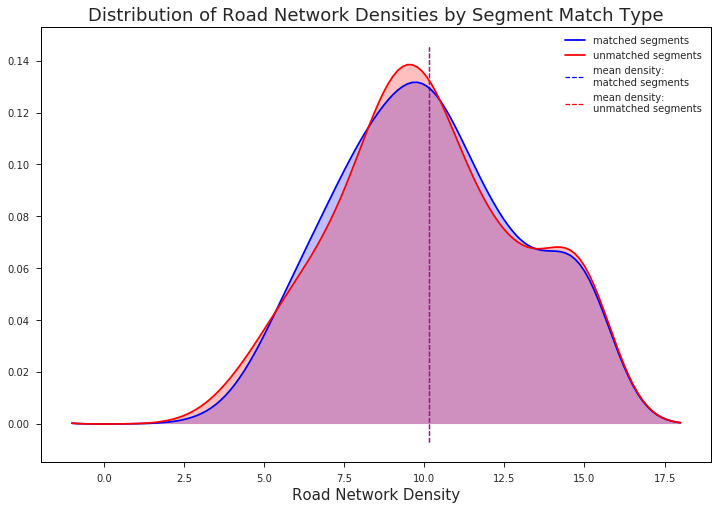

In [6]:
val.plot_density_kdes(densityDf)

The chart above shows that the distribution of road network densities are actually much more similar than we might expect. It suggests that road network density on its own would not make a good predictor of match rate. 

There is, however, a clear difference between the distributions, albeit somewhat small in magnitude. Most importantly, this difference is in the direction that matches our intuition: unmatched segments have a higher mean road network density than their matched counterparts. Given that the distributions were calculated over such a wide swath of sample data -- nearly 900,000 individual road segments from 750 routes in 15 different cities -- we can be confident that the trend is real.

Drilling down a bit deeper, we see that this trend persists across all different GPS sample rates and noise levels: 

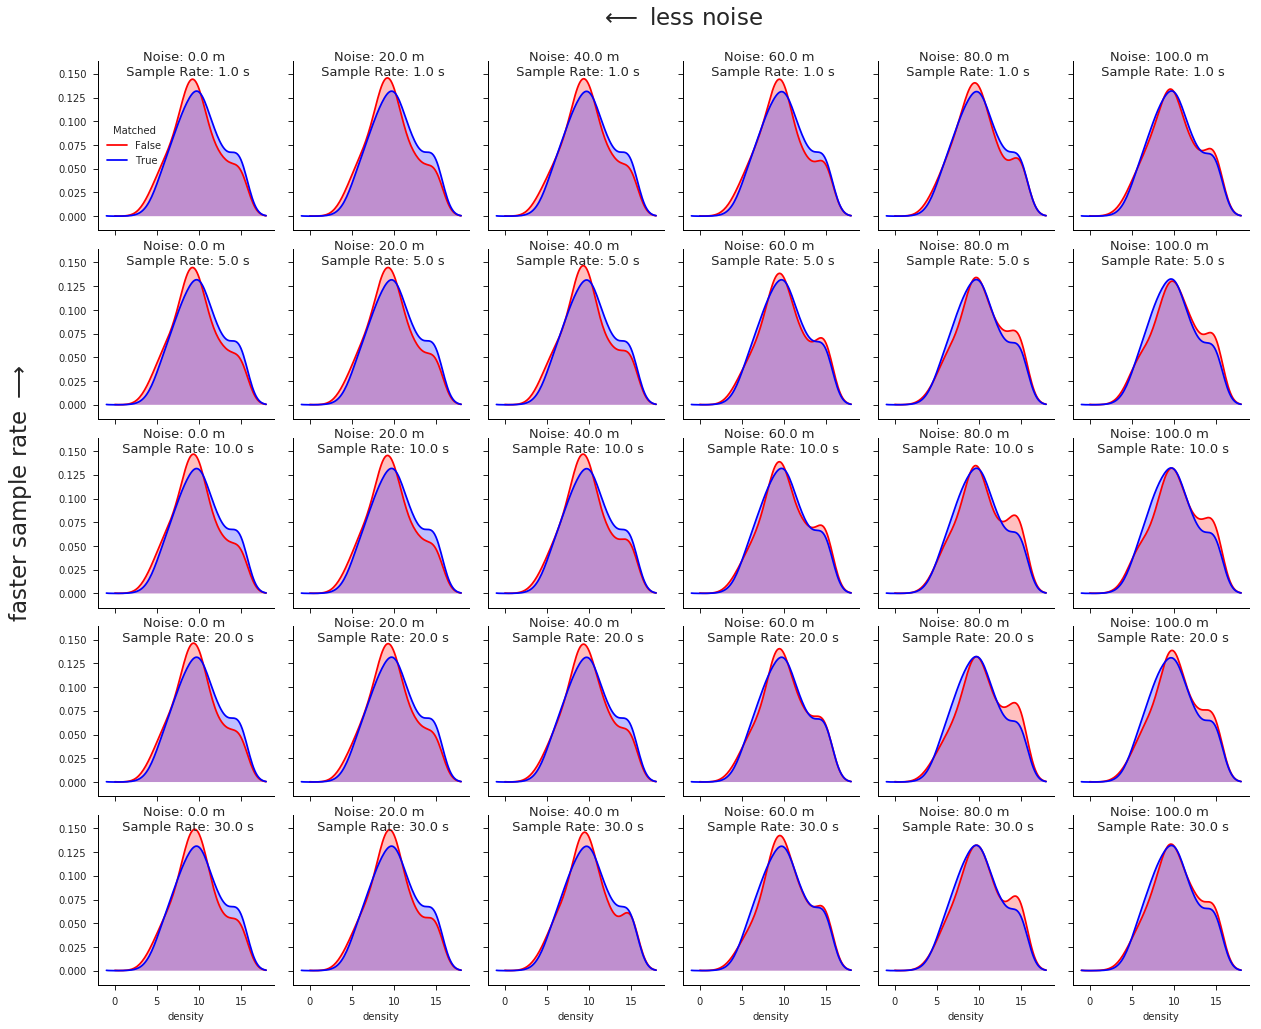

In [7]:
val.plot_density_kdes_gridded(densityDf, saveFig=True)

### d) Normalize our distributions

Although the evidence so far does suggest a **weakly negative** influence of road network density on map-matching performance, the actual empirical relationship between the two is somewhat obscured by the KDE's. Since KDE plots are essentially visualizing a frequency distribution, we may be missing important visual information in the tail ends of the distributions where there simply aren't as many data points.

Since we don't really care about the frequency with which different road network densities occur, but rather how these densities impact map-matching performance when they _do_ occur, we can normalize our results by the number of segments we observed at each road network density level (1 - 16).

In [8]:
freqDf = val.normalize_densities(densityDf, sampleRates, noiseLevels)

The first 10 rows from our new dataframe:

In [9]:
freqDf.head(10)

,sample_rate,noise,density,matched,frequency
segment,,,,,
0,1.0,0.0,6.0,False,0.045847
1,1.0,0.0,6.0,True,0.954153
2,1.0,0.0,7.0,False,0.041337
3,1.0,0.0,7.0,True,0.958663
4,1.0,0.0,8.0,False,0.045161
5,1.0,0.0,8.0,True,0.954839
6,1.0,0.0,9.0,False,0.060564
7,1.0,0.0,9.0,True,0.939436
8,1.0,0.0,10.0,False,0.041168


Now that we are dealing with the normalized match frequencies, there is no need to visualize both the matched and unmatched rates -- they will always sum to 1. Instead, we will focus our attention on the percentage of **unmatched segments** at each discrete variable level, since this number more directly relates to the relationship between road network density and match error.

Plotting just the normalized frequencies of segment types where `matched == False` we arrive at the following:

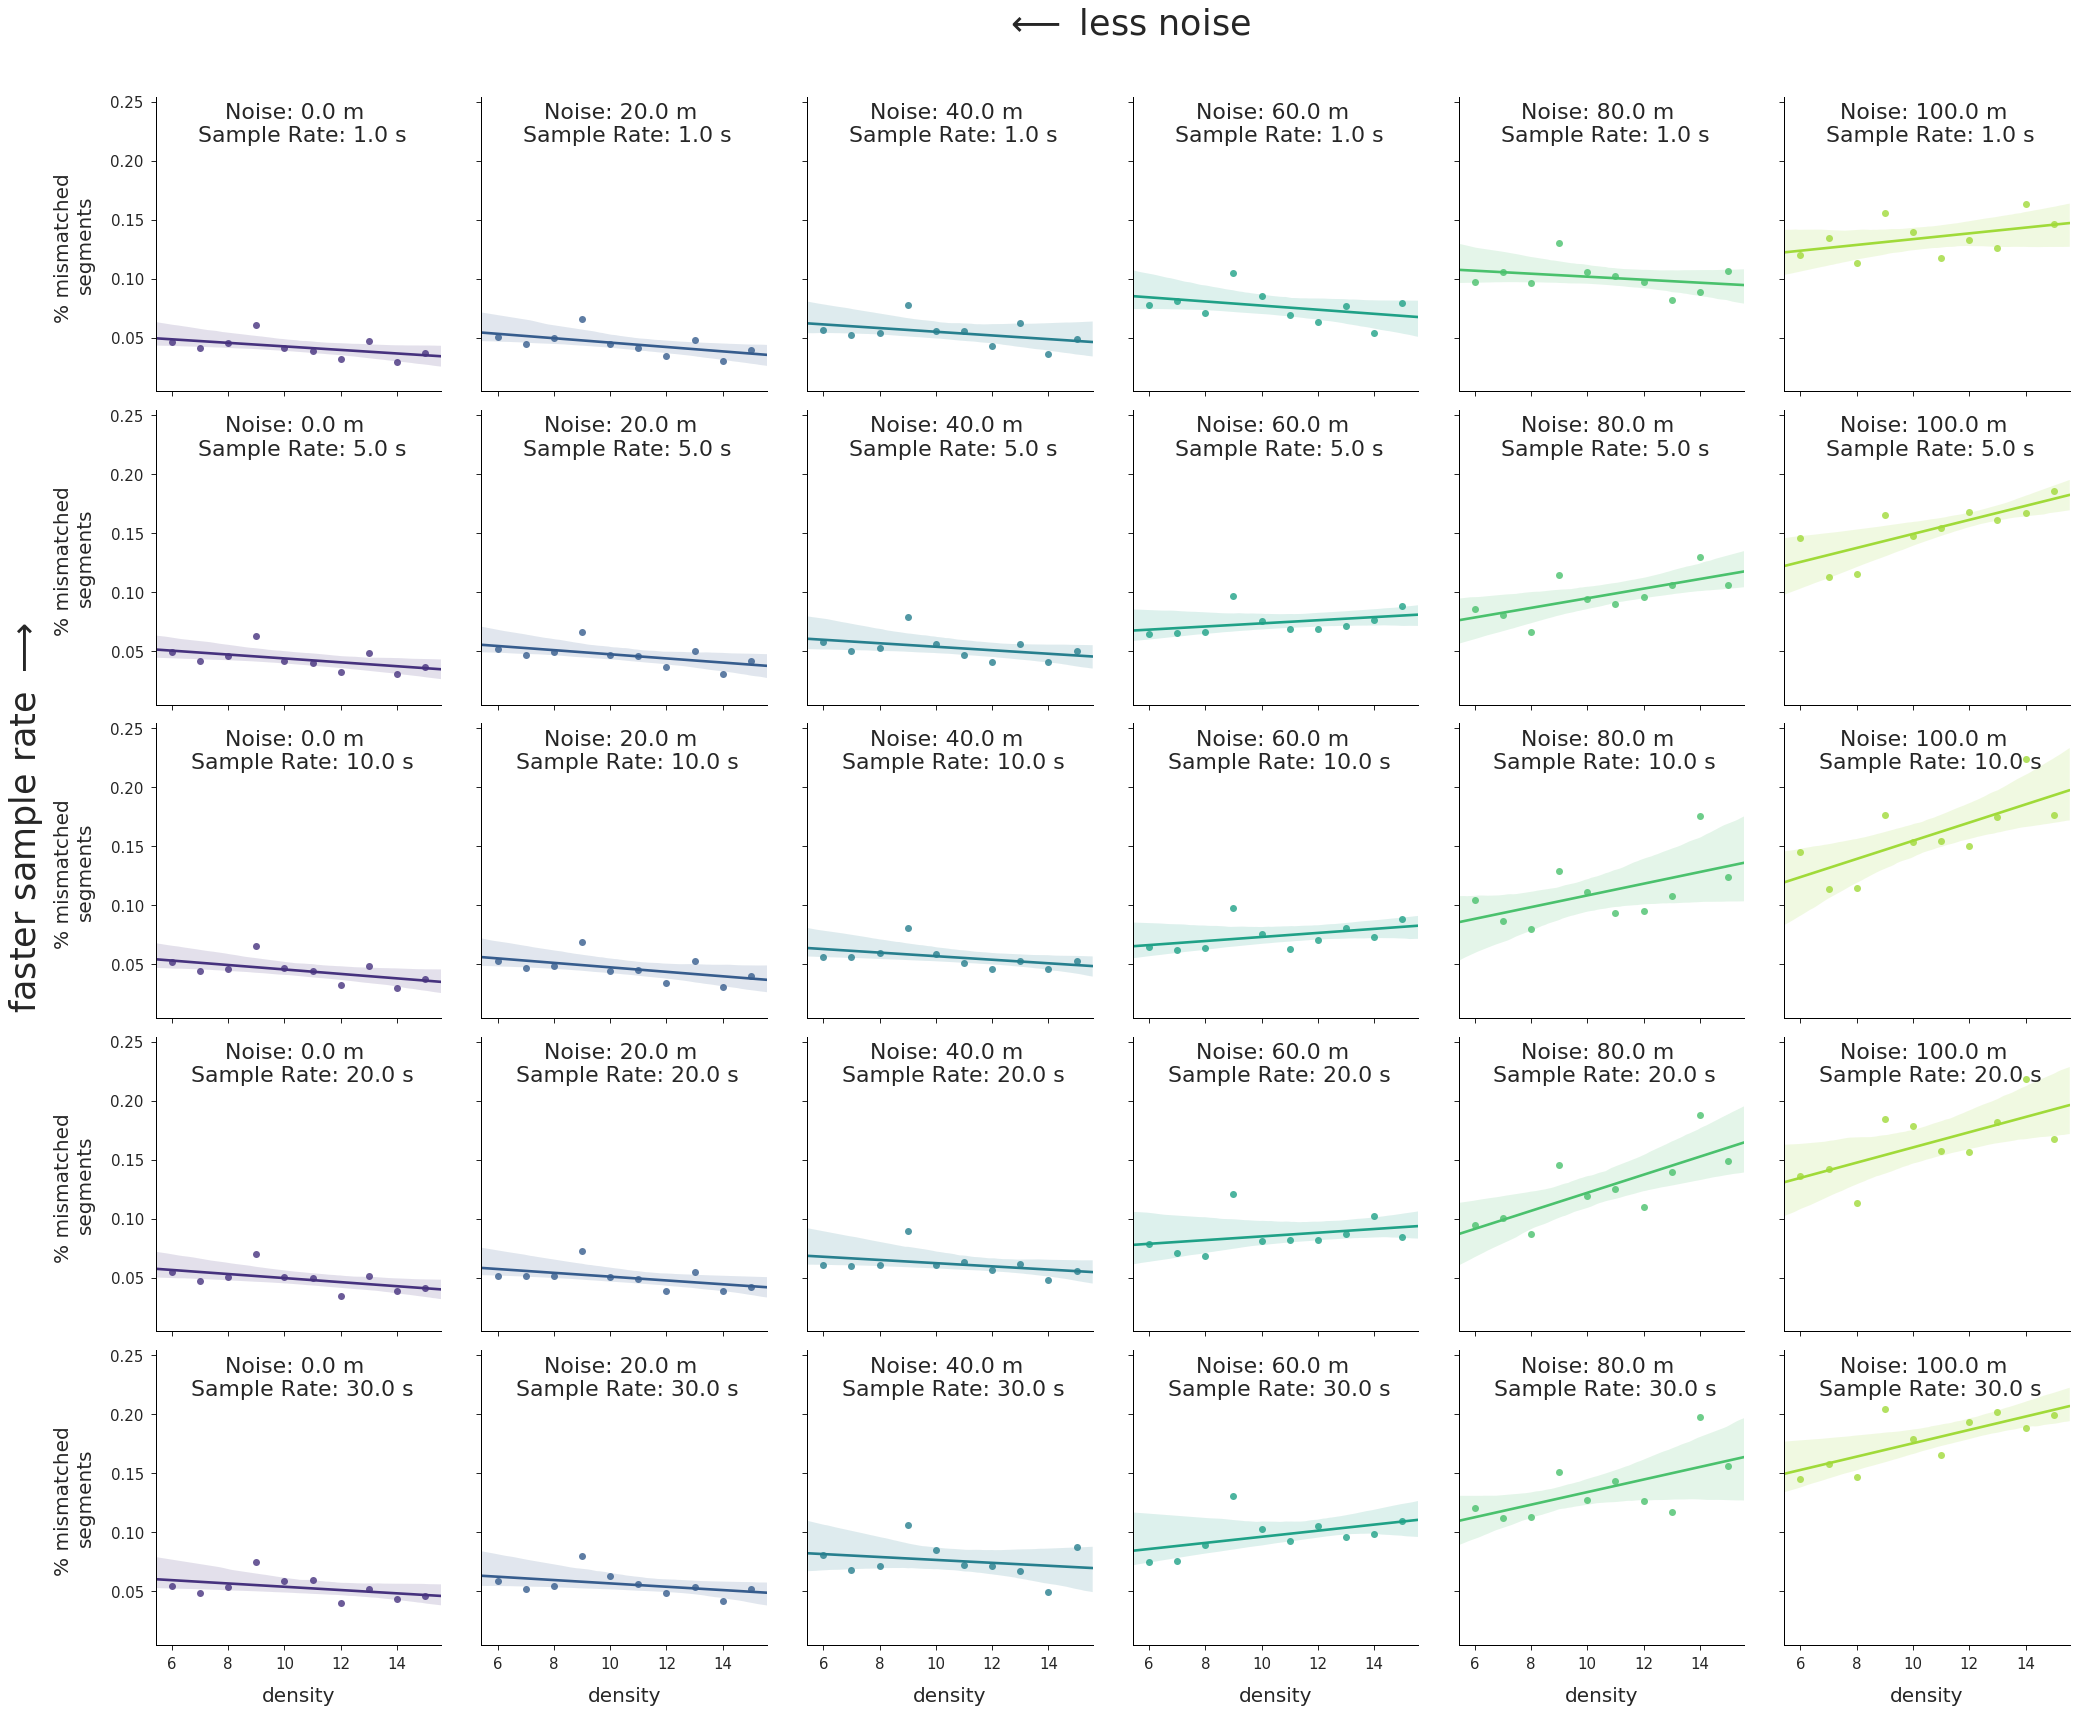

In [10]:
val.plot_density_regressions(freqDf)

These charts highlight a number of trends that are worth pointing out:
1. There is a clear positive correlation between road network density on the `X` axes and error rate on the `Y` axes for the majority of noise levels and sample rates. In short, _**the greater the density of the road network the worse the map-matching results will be**_.
2. The strength of this relationship increases with increasing noise, from nearly 0 correlation at the lowest levels of noise to a trendline of nearly 3% error per unit of density at 100 m of GPS noise. In terms of real numbers, a route with an average density of 12 could expect up to **12% greater** mismatches than a route traversed in a area with a road network density of ~8. 

      <table>
    <caption align="bottom">1 Sq. Mile from each road network (generated using <href>[osmnx](https://github.com/gboeing/osmnx)</href>)</caption>
    <tr>
        <td>
            <img src='images/irvine2.png'>
            <figcaption>Irvine, CA - Density: ~8</figcaption>
        </td>
        <td>
            <img src='images/sf2.png'>
            <figcaption>SF, CA - Density: ~12</figcaption>
        </td>
    </tr>
</table>

3. Overall error rate increases with GPS noise. This is actually a trend we _aren't_ interested in, since we've already assessed the impact of GPS noise on match accuracy [at length](http://nbviewer.jupyter.org/github/opentraffic/reporter-quality-testing-rig/blob/master/notebooks/map_matching_part_I.ipynb?flush_cache=true#3.-Visualize-the-Scores). Thus the relative positions of the regression lines along the `Y` axes in the charts only serve as a distraction. In the next section, we'll fix that problem.

### e) Data standardization

The process of data _standardization_ occurs in two steps:
1. **Center** a dataset about its own mean (i.e. $\mu = 0$)
2. **Scale** the dataset relative to its own standard deviations (i.e. $\sigma = 1$)

By standardizing our data across noise levels, we'll eliminate in this way, we can visualize our data on a single set of axes that highlights just the change in slope between the trendlines at varying levels of GPS noise:

In [11]:
stdDf = val.standardize_densities(densityDf)

In [12]:
stdDf.head()

,sample_rate,density,noise,pct_by_match_type,stddev_match_pct,mean_match_pct,match_rate_normed,above_avg
0,1.0,6.0,0.0,0.045847,0.008762,0.041751,0.47,True
1,1.0,7.0,0.0,0.041337,0.008762,0.041751,-0.05,False
2,1.0,8.0,0.0,0.045161,0.008762,0.041751,0.39,True
3,1.0,9.0,0.0,0.060564,0.008762,0.041751,2.15,True
4,1.0,10.0,0.0,0.041168,0.008762,0.041751,-0.07,False


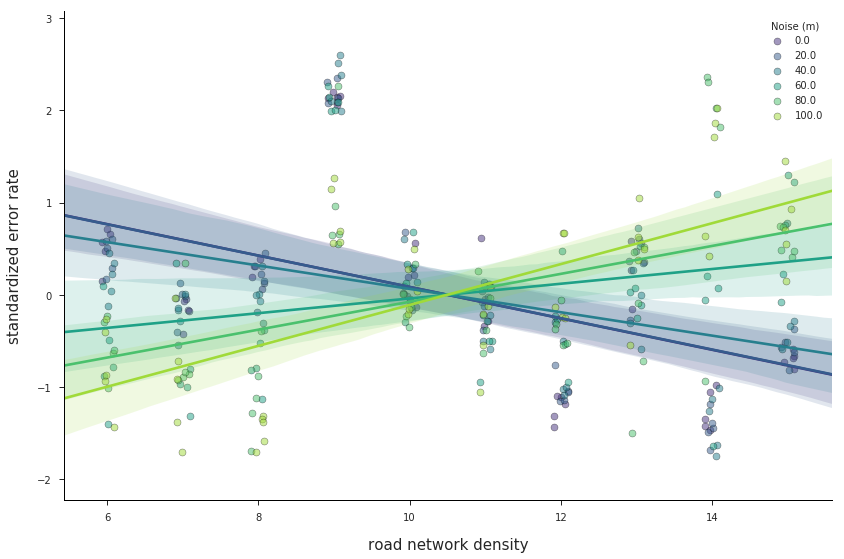

In [13]:
g = sns.lmplot('density','match_rate_normed', stdDf, hue='noise', size=8, aspect=1.5, palette='viridis',
              x_jitter=0.1, scatter_kws={'alpha':0.5, 'edgecolor':'k', 'linewidths':0.5}, legend=False)
g.set_ylabels('standardized error rate', fontsize=15)
g.set_xticklabels(fontsize=10)
g.set_yticklabels(fontsize=10)
g.set_xlabels('road network density', fontsize=15)
plt.legend(title='Noise (m)')

With standardized data, we can more clearly see how road network density exerts an increasingly negative effect on segment match error rate as the level of GPS noise increases. The actual values on the `Y` axis, however, are unitless, and therefore less easily interpreted.

For some bonus eye candy, we can represent the same data with an interative parallel coordinates plot (as suggested by our good buddy [Will Geary](https://willgeary.github.io/)). This interactive mode of visualization allows us to dynamically filter our data to see how certain variables interact with others. In graph below, drag the **<span style="color:pink">pink</span>** line up and down on the road network density axis and watch how the range of standardized error rates change in response:

In [14]:
data = [
    go.Parcoords(
        line = dict(color = stdDf['noise']),
        dimensions = list([
            dict(constraintrange = [6,8],
                 label = 'Road Network Density', values = stdDf['density'],
                tickvals = stdDf['density'].unique()),
            dict(constraintrange = [1,30],
                 label = 'Sample Rate (s)', values = stdDf['sample_rate'],
                tickvals = stdDf['sample_rate'].unique()),
            dict(constraintrange = [0,100],
                 label = 'Noise (m)', values = stdDf['noise'],
                tickvals = stdDf['noise'].unique()),
            dict(
                 label = 'Standardized Error Rate', values = stdDf['match_rate_normed'])
            
        ]),
        opacity=0.5,
        labelfont = dict(size = 13)
    )
]

py.iplot(data, filename = 'parcoords-advanced')

You can also create new filters by clicking and dragging on the other axes to draw a filter of an arbitrary size.

## 2. Case Study: Irvine, CA vs. San Francisco, CA

Clearly the built environment has a significant impact on the likelihood of matching a GPS measurement to its correct road segment. This is a particularly notable finding not just because a data provider/end user might expect worse performerance in the denser portions of their service areas, but because two different data providers/end users might expect entirely different performance based on the general character of their service territories. 

#### Irvine, California

Irvine is a an affluent, planned city in southern California, just south of Los Angeles. It was planned by the [Irvine Company](https://en.wikipedia.org/wiki/Irvine_Company), which continues to control development in the area. Irvine is home to UC Irvine, which is also the city's largest employer. The city has a population density of 4,057.85/sq mi according to [Wikipedia](https://en.wikipedia.org/wiki/Irvine,_California).

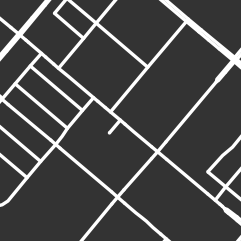

In [17]:
cityName = 'Irvine, CA'
point = (33.694981, -117.841375)
fig, ax = ox.plot_figure_ground(point=point, filename=place, network_type='drive', default_width=6, dpi=dpi)
Image('{}/{}.{}'.format(img_folder, cityName, extension), height=size, width=size)

In [3]:
routeList = val.get_routes_by_length(cityName, 1, 5, 100, mapzenKey)

In [9]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]
irvMatchDf, irvSpeedDf, irvDensityDf = val.get_route_metrics(cityName, routeList, sampleRates, noiseLevels, saveResults=False)

In [15]:
irvMatchDf = pd.read_csv('irvine_matches_100.csv')

#### San Francisco, California

San Francisco is the second most densely populated major city in the United States, with a population density of 17,246.4/sq mi according to [Wikipedia](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population_density). It is perhaps _the_ major west coast hub for the financial and technology sectors, and is entirely contained within a peninsula roughly 7 miles by 7 miles. 

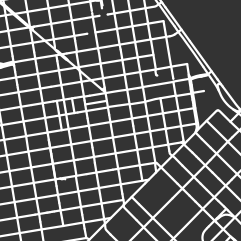

In [16]:
place = 'sf'
point = (37.793897, -122.402189)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi, network_type='drive')
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

In [3]:
cityName = 'San Francisco'
routeList = val.get_routes_by_length(cityName, 1, 5, 100, mapzenKey)

In [188]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]
sfMatchDf, sfSpeedDf, sfDensityDf = val.get_route_metrics(cityName, routeList, sampleRates, noiseLevels, saveResults=False)

In [16]:
sfMatchDf = pd.read_csv('sf_matches_100.csv')

#### Comparison

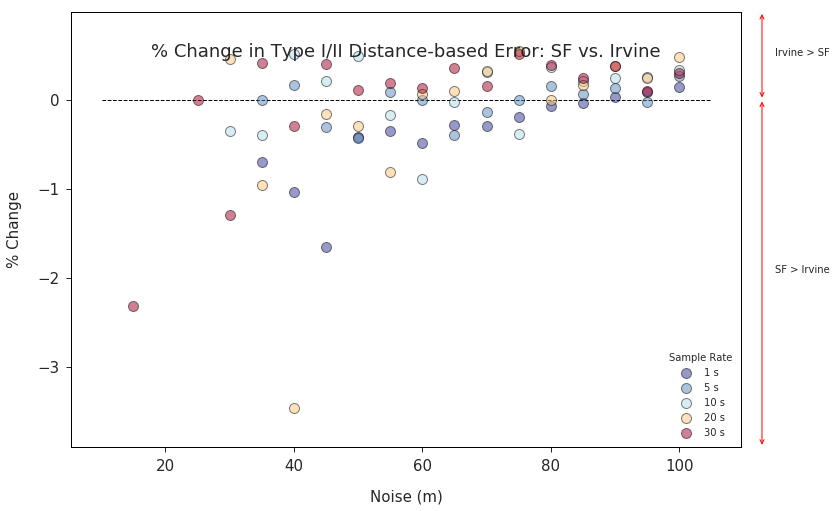

In [17]:
val.plot_regional_comparison(sfMatchDf, irvMatchDf, sampleRates, cityNameA='SF', cityNameB='Irvine')

## 3. Conclusions

In this analysis, we spent 


This may seem obvious, but it is extremely important to understand that there are structural limitations associated with certain land use types that undercut the performance of even the most technologically advanced map-matching solutions. Both data providers and end users should understand that **map-matching will be less accurate in downtown locations than out in the suburbs**. For the purposes of Open Traffic, the sheer volume of traffic data being generated in a central business district should more than make up for the discrepancy in accuracy.